# Loading the dataset and getting necessary libraries

In [203]:
!pip install pmdarima -q

In [204]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
import warnings
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot, quarter_plot
from sklearn.metrics import mean_absolute_percentage_error

warnings.filterwarnings('ignore')
rcParams["figure.figsize"] = 10, 6

In [205]:
data = pd.read_csv("/content/drive/MyDrive/Datasets/airline-passengers.csv", parse_dates=["month"], index_col="month")
data = data.asfreq('MS')
data.rename(columns={"total_passengers":"number_of_passengers"}, inplace=True)
data.head()

,number_of_passengers
month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [206]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Freq: MS
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   number_of_passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB


# Visual Insights

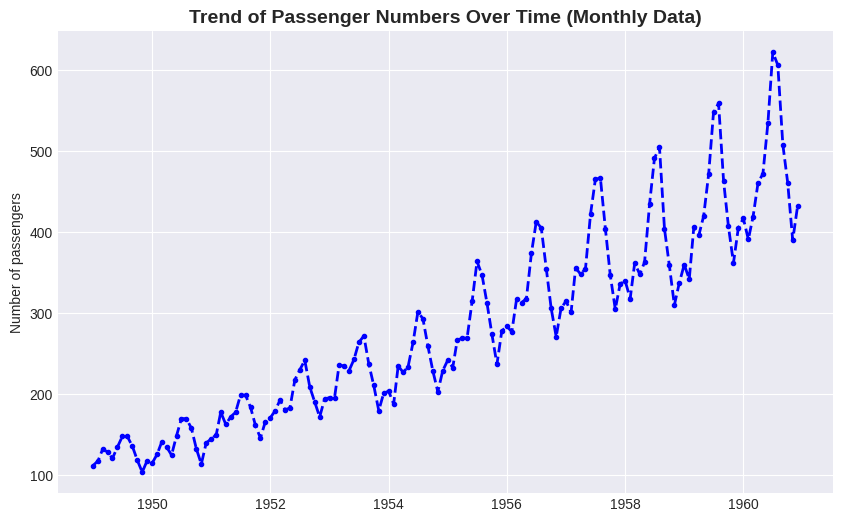

In [207]:
plt.plot(data, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=3)
plt.ylabel("Number of passengers")
plt.title("Trend of Passenger Numbers Over Time (Monthly Data)", fontsize=14, fontweight='bold')
plt.show()

**Note:** The chart clearly shows an upward trend in the number of passengers over time. The peaks and troughs appear to occur at relatively consistent intervals, reinforcing the idea of a yearly seasonal cycle. While the overall trend is upward, it's worth noting that the amplitude (the height of the peaks and depth of the troughs) seems to be increasing over time. This suggests that the seasonal fluctuations are becoming more pronounced as the overall passenger numbers grow.

In [208]:
max_date = data['number_of_passengers'].idxmax()
print(f"The highest number of passengers was on: {max_date}")

The highest number of passengers was on: 1960-07-01 00:00:00


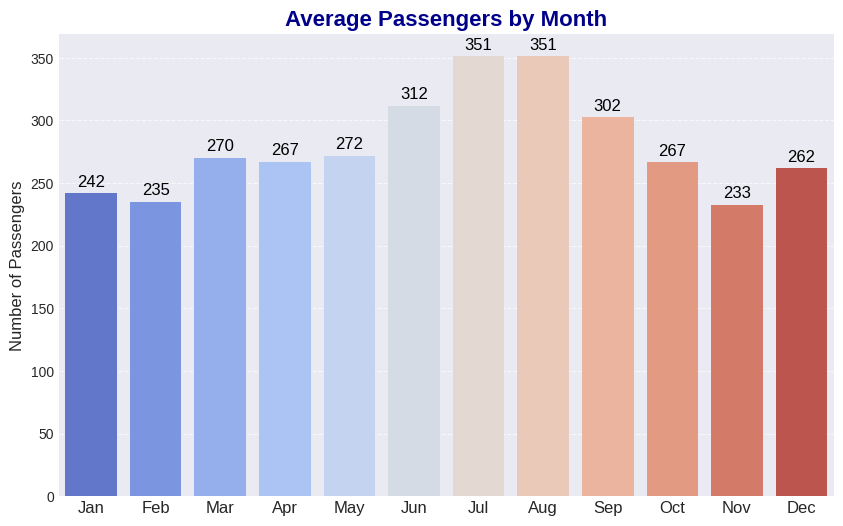

In [209]:
data["month_of_calendar"] = data.index.month
monthly_passengers = data.groupby('month_of_calendar')['number_of_passengers'].mean()

plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=monthly_passengers.index, y=monthly_passengers.values, palette='coolwarm')

plt.title('Average Passengers by Month', fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel('', fontsize=12)
plt.ylabel('Number of Passengers', fontsize=12)

plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], fontsize=12)

plt.grid(axis='y', linestyle='--', alpha=0.7)

for p in barplot.patches:
    barplot.annotate(f'{p.get_height():,.0f}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     fontsize=12, color='black',
                     xytext=(0, 8), textcoords='offset points')

plt.show()

In [210]:
data.drop("month_of_calendar", axis=1, inplace=True)

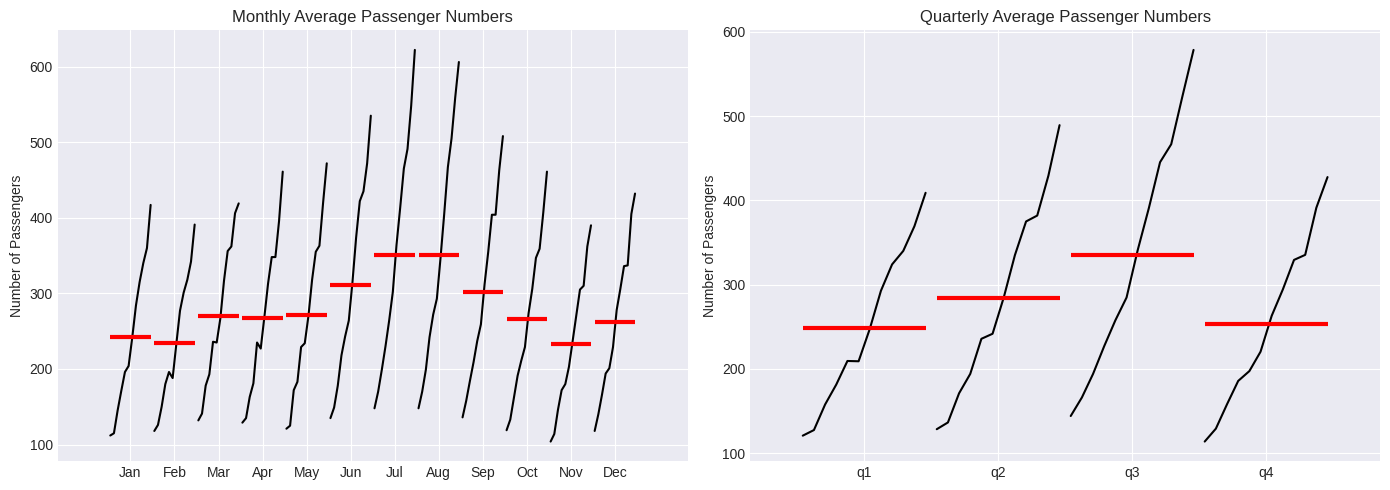

In [211]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

month_plot(data['number_of_passengers'].resample('M').mean(),
           ylabel="Number of Passengers", ax=axes[0])
axes[0].set_title("Monthly Average Passenger Numbers")

quarter_plot(data['number_of_passengers'].resample('Q').mean(),
             ylabel="Number of Passengers", ax=axes[1])
axes[1].set_title("Quarterly Average Passenger Numbers")

plt.tight_layout()

plt.show()

**Note**: The plots reveal a positive trend of increasing passenger numbers with a clear seasonal pattern. The data strongly suggests that the airport or transportation service is experiencing consistent growth in passenger numbers over the year.The peak passenger numbers during the summer months (July-September) indicate a strong seasonal influence, likely due to tourism or increased travel during this period.

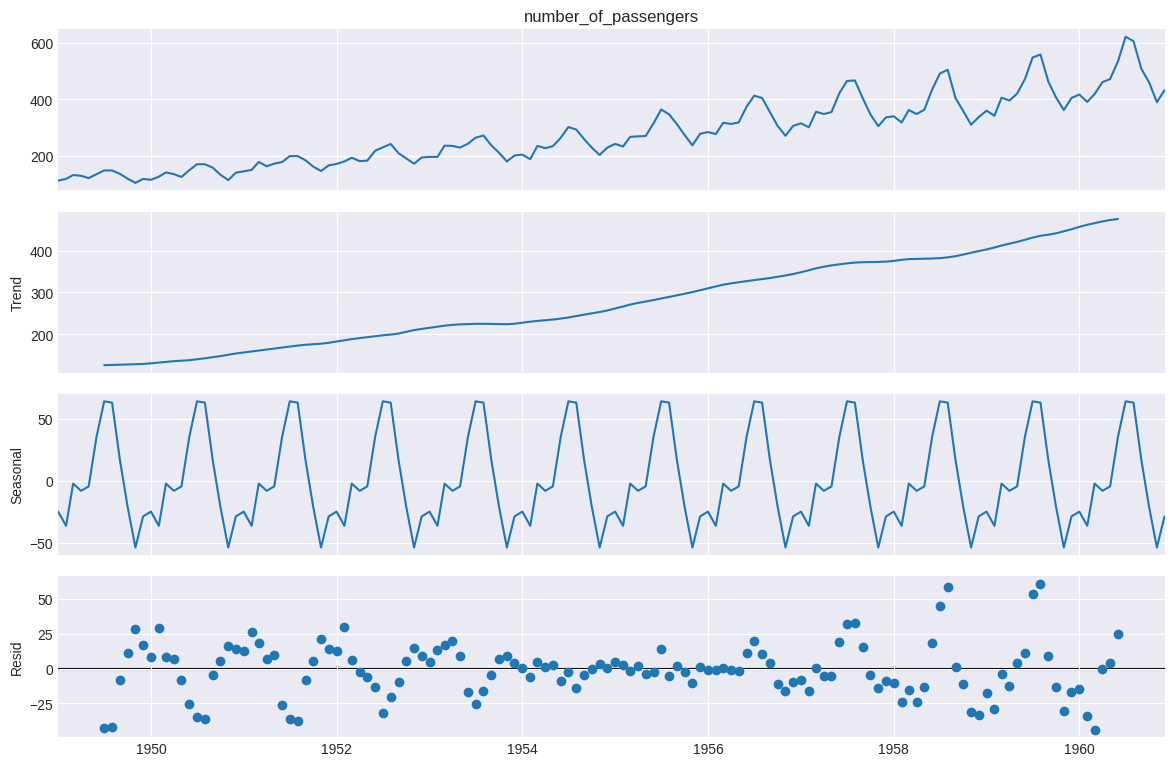

In [212]:
decomposition = seasonal_decompose(data['number_of_passengers'], model='additive', period=12)
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

1.  **Trend:** indicates a sustained growth in passenger numbers over the years. The flattening might suggest a temporary slowdown or a change in the growth rate, but the dominant trend is positive.
2. **Seasonal:** The consistent pattern suggests that the seasonality is a persistent factor.
3. **Resid:** The residual component shows a scatter of points around zero, with no clear pattern or trend. The fluctuations appear to be random.

# Dickey Fuller-test

In [213]:
print("Results of Dickey-Fuller Test (base test): ")
dickey_fuller = adfuller(data["number_of_passengers"], autolag='AIC')
output = pd.Series(dickey_fuller[0:4], index=["Test Statistic", "p-value", "#Lags Used", "Number of observation"])

for key, value in dickey_fuller[4].items():
    output["Critical Value (%s)"%key] = value

print(output)

Results of Dickey-Fuller Test (base test): 
Test Statistic             0.815369
p-value                    0.991880
#Lags Used                13.000000
Number of observation    130.000000
Critical Value (1%)       -3.481682
Critical Value (5%)       -2.884042
Critical Value (10%)      -2.578770
dtype: float64


**NOTE:** Since the p-value is high (~ 0.9919), which is greater than common significance levels (like 0.05), I would actually fail to reject the null hypothesis in this case, so my data is not stationary.

# Preparation for SARIMA

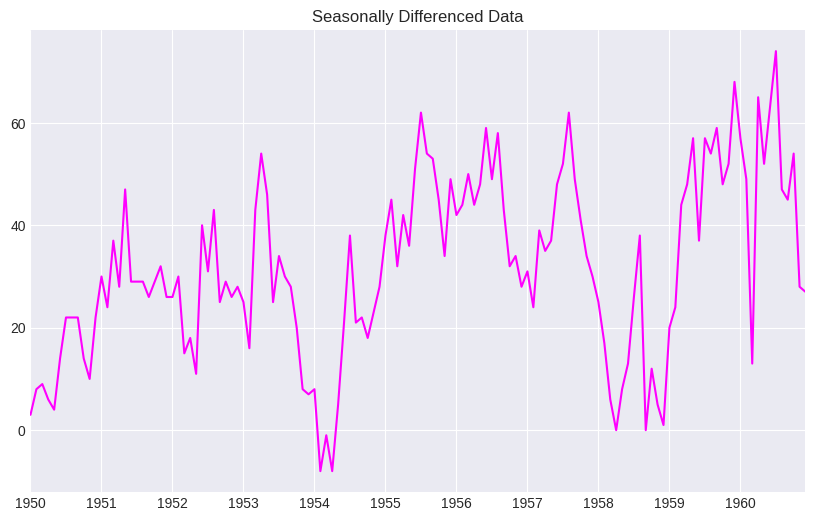

In [214]:
data_seasonal_diff = data.diff(12).dropna()

data_seasonal_diff.plot(title='Seasonally Differenced Data', color='magenta', legend=False)
plt.xlabel('')
plt.show()

In [215]:
dickey_fuller_second = adfuller(data_seasonal_diff['number_of_passengers'], autolag='AIC')

print(f"Test Statistic: {dickey_fuller_second[0]}")
print(f"p-value: {dickey_fuller_second[1]}")
print(f"Critical Values: {dickey_fuller_second[4]}")

if dickey_fuller_second[1] < 0.05:
    print("\nThe series is now stationary.")
else:
    print("\nThe series is still not stationary.")

Test Statistic: -3.383020726492481
p-value: 0.011551493085514952
Critical Values: {'1%': -3.4816817173418295, '5%': -2.8840418343195267, '10%': -2.578770059171598}

The series is now stationary.


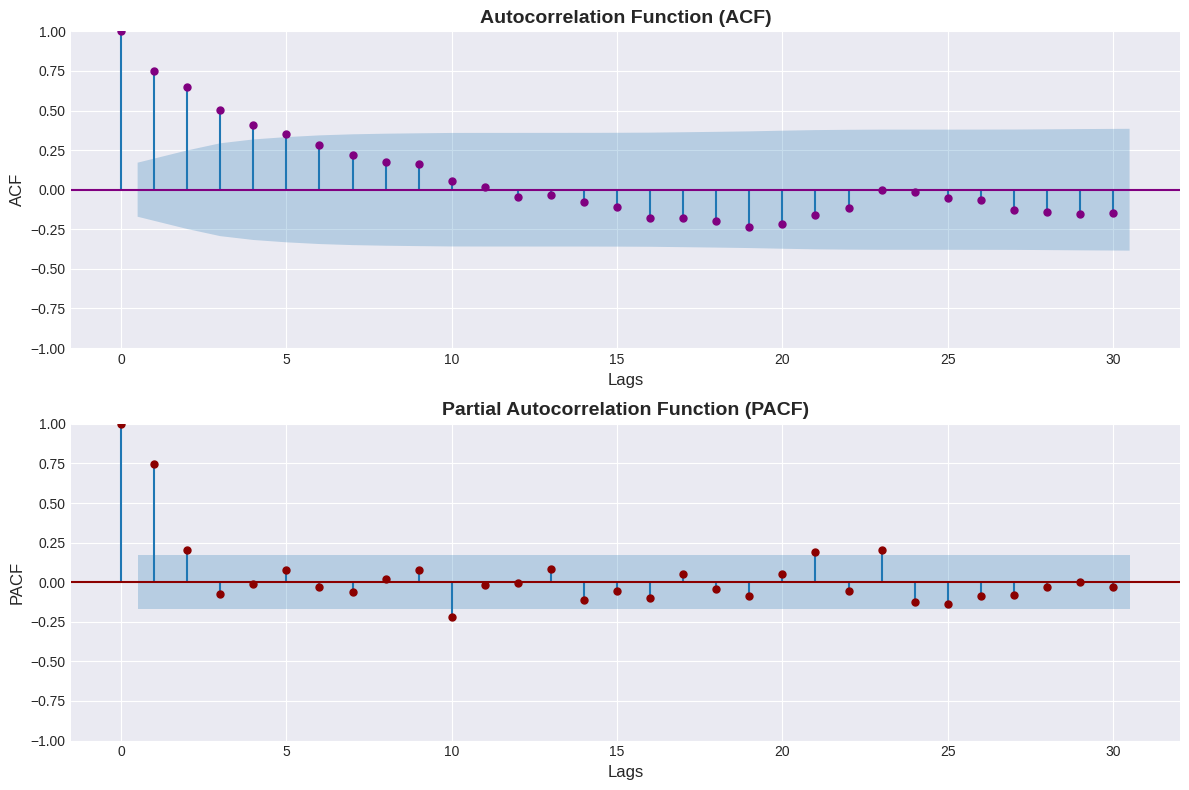

In [216]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(data_seasonal_diff, ax=axes[0], lags=30, color='purple')
axes[0].set_title("Autocorrelation Function (ACF)", fontsize=14, fontweight='bold')
axes[0].set_xlabel("Lags", fontsize=12)
axes[0].set_ylabel("ACF", fontsize=12)

plot_pacf(data_seasonal_diff, ax=axes[1], lags=30, color='darkred')
axes[1].set_title("Partial Autocorrelation Function (PACF)", fontsize=14, fontweight='bold')
axes[1].set_xlabel("Lags", fontsize=12)
axes[1].set_ylabel("PACF", fontsize=12)

plt.tight_layout()
plt.show()

- **p (AR component):** Since the PACF shows a significant spike at lag 1 and then cuts off, it suggests an AR(1) component. Therefore, we should start with p = 1.
- **q (MA component):** The ACF shows a gradual decay rather than a sharp cutoff, indicating that the process is not purely MA. However, the significant spikes at the initial lags might suggest a small MA component. We can start with q = 0 or q = 1.

# Training and model evaluation

In [217]:
# Train-Test Split
train_size = len(data) - 5
train_data = data[:train_size]
test_data = data[train_size:]

In [218]:
sarima_base = sm.tsa.SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
results = sarima_base.fit()

In [219]:
predictions = results.get_forecast(steps=5)
predicted_values = predictions.predicted_mean

In [220]:
rss = np.sum((test_data - predicted_values) ** 2)
mape = mean_absolute_percentage_error(test_data, predicted_values)
print(f"RSS: {rss}")
print(f"MAPE: {mape * 100:.2f}%")

RSS: number_of_passengers    0.0
1960-08-01 00:00:00     0.0
1960-09-01 00:00:00     0.0
1960-10-01 00:00:00     0.0
1960-11-01 00:00:00     0.0
1960-12-01 00:00:00     0.0
dtype: float64
MAPE: 6.68%


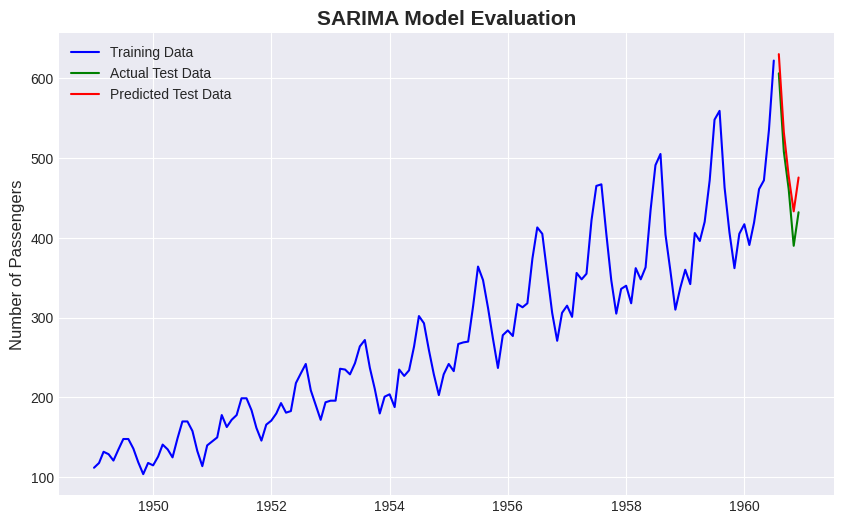

In [221]:
plt.figure(figsize=(10, 6))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='green')
plt.plot(test_data.index, predicted_values, label='Predicted Test Data', color='red')
plt.title('SARIMA Model Evaluation', fontsize=15, fontweight='bold')
plt.ylabel("Number of Passengers", fontsize=12)
plt.legend()

plt.show()

# Forecasting

In [222]:
y = data['number_of_passengers']

auto_model = auto_arima(
    y,
    seasonal=True,
    m=12,
    trace=True,
    suppress_warnings=True,
    stepwise=True,
    information_criterion='aic',
)

print("Best model found by auto_arima:", auto_model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,1,1)[12]             : AIC=1020.048, Time=9.53 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.06 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=1.00 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=1.24 sec
 ARIMA(2,1,2)(0,1,1)[12]             : AIC=1019.935, Time=3.68 sec
 ARIMA(2,1,2)(0,1,0)[12]             : AIC=1019.290, Time=1.63 sec
 ARIMA(2,1,2)(1,1,0)[12]             : AIC=1019.546, Time=5.78 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=1024.160, Time=1.95 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=1017.847, Time=0.67 sec
 ARIMA(2,1,1)(1,1,0)[12]             : AIC=1017.914, Time=0.77 sec
 ARIMA(2,1,1)(0,1,1)[12]             : AIC=1018.359, Time=0.78 sec
 ARIMA(2,1,1)(1,1,1)[12]             : AIC=1018.248, Time=1.62 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=1022.393, Time=0.10 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=1022.393, Time=0.08 sec
 ARIMA(3,1,1)(0,1,0

In [223]:
p, d, q = 2, 1, 1
P, D, Q, m = 0, 1, 0, 12
sarima_model = sm.tsa.SARIMAX(data, order=(p, d, q), seasonal_order=(P, D, Q, m))
sarima_result = sarima_model.fit()

In [225]:
forecast = sarima_result.get_forecast(steps=24)
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

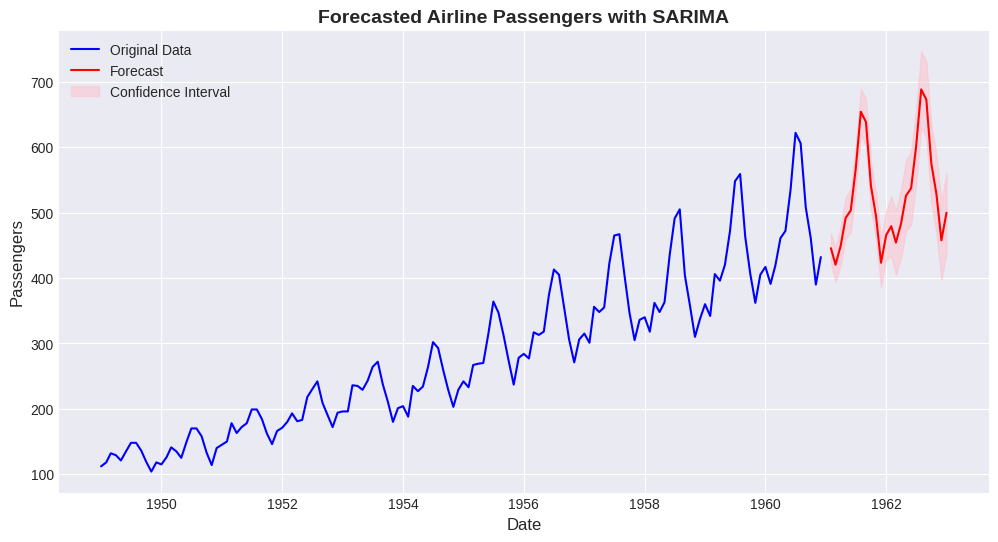

In [226]:
plt.figure(figsize=(12, 6))
plt.plot(data.index, data, label='Original Data', color='blue')
plt.plot(pd.date_range(data.index[-1], periods=24 + 1, freq='M')[1:], forecast_values, label='Forecast', color='red')

plt.fill_between(pd.date_range(data.index[-1], periods=24 + 1, freq='M')[1:],
                 conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.5, label="Confidence Interval")

plt.title('Forecasted Airline Passengers with SARIMA', fontsize=14, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Passengers", fontsize=12)
plt.legend()
plt.grid(True)

plt.show()

# Final Conclusion
The SARIMA model provides a good fit, with a low MAPE indicating accurate predictions.